In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('/home/lin/教材/MearchineLearning/assignmentOneData/CrisisPrediction.csv')

In [3]:
list(data.columns.values)

['year', 'country', 'loans1', 'cpi', 'credit_to_GDP', 'crisisST']

In [4]:
data['logRetCre'] = np.log(data['loans1']/data['cpi']).diff()

In [5]:
data['lag_1'] = data['logRetCre'].shift()
data['lag_2'] = data['logRetCre'].shift(2)
data['lag_3'] = data['logRetCre'].shift(3)
data['lag_4'] = data['logRetCre'].shift(4)
data['lag_5'] = data['logRetCre'].shift(5)
data['credit'] = data['credit_to_GDP'].shift()

data = data.dropna()
preW = data[data['year']<=1938]
postW = data[data['year']>=1948]

In [6]:
data.head(10)

,year,country,loans1,cpi,credit_to_GDP,crisisST,logRetCre,lag_1,lag_2,lag_3,lag_4,lag_5,credit
6,1879,AUS,99.830002,2.750000,0.388142,0,-0.010011,0.066657,0.126886,0.058240,0.081858,0.041862,0.411609
7,1880,AUS,91.010002,2.666667,0.329508,0,-0.061728,-0.010011,0.066657,0.126886,0.058240,0.081858,0.388142
8,1881,AUS,111.970000,2.625000,0.385439,0,0.223010,-0.061728,-0.010011,0.066657,0.126886,0.058240,0.329508
9,1882,AUS,139.880000,2.666667,0.446616,0,0.206805,0.223010,-0.061728,-0.010011,0.066657,0.126886,0.385439
10,1883,AUS,151.120000,2.958333,0.461999,0,-0.026507,0.206805,0.223010,-0.061728,-0.010011,0.066657,0.446616
11,1884,AUS,161.780000,3.000000,0.482493,0,0.054177,-0.026507,0.206805,0.223010,-0.061728,-0.010011,0.461999
12,1885,AUS,178.620000,3.000000,0.520000,0,0.099023,0.054177,-0.026507,0.206805,0.223010,-0.061728,0.482493
13,1886,AUS,185.320010,3.000000,0.517220,0,0.036823,0.099023,0.054177,-0.026507,0.206805,0.223010,0.520000
14,1887,AUS,192.830000,2.916667,0.505717,0,0.067896,0.036823,0.099023,0.054177,-0.026507,0.206805,0.517220
15,1888,AUS,223.950000,2.791667,0.552009,0,0.193416,0.067896,0.036823,0.099023,0.054177,-0.026507,0.505717


0.6373277827336704
0.4518906730102092
0.6286424526999033
0.5177922018137459
0.697533908754624
0.7200369913686806


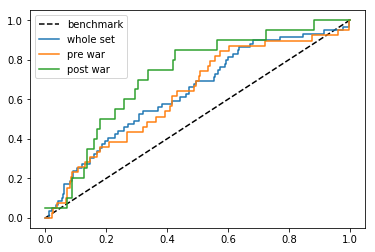

In [7]:
#logistic with whole data set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def in_sample_logistic(training, sign, credit=False):
    if credit is True:
        X = training[['lag_2', 'credit']]
#from the paper, lag_2 cpi nomalized loan is the most significent one and credit add prediction power, I tried all 
#five lags and it confirmed this results However, the credit seems mostly add power in post war period. Possible
#reason is prewar, credit to GBP is steady thus cannot add much info to predict crisis
    else:
         X = training[['lag_2']]
    y = training['crisisST']
    logis = LogisticRegression()
    logis.fit(X, sign * y)
    pre_pro = logis.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pre_pro)
    auc = roc_auc_score(y, pre_pro)

    print(auc)
    return fpr, tpr, auc

data_fpr, data_tpr, _ = in_sample_logistic(data, -1)
in_sample_logistic(data, -1, True)

pre_fpr, pre_tpr, _ = in_sample_logistic(preW, -1)
in_sample_logistic(preW, -1, True)

in_sample_logistic(postW, 1)
post_fpr, post_tpr, _ = in_sample_logistic(postW, 1, True)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(pre_fpr,pre_tpr)
plt.plot(post_fpr,post_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])

0.6932874354561103
0.44922547332185886
0.7010233918128654
0.7309941520467836
0.6987704918032787
0.8169398907103825


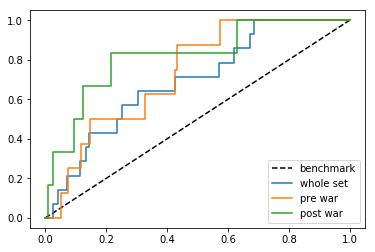

In [8]:
def out_of_sample_logistic(whole, test, sign, credit=False):
    if credit is True:
        X = whole[['lag_2', 'credit']]
    else:
         X = whole[['lag_2']]
    y = whole['crisisST']
    
    trainSize = int(whole.shape[0]*(1-test))
    X_train = X[:trainSize]
    X_test = X[trainSize:]
    y_train = y[:trainSize]
    y_test = y[trainSize:]
    
    logis = LogisticRegression()
    logis.fit(X_train, sign * y_train)
    pre_pro = logis.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, pre_pro)
    auc = roc_auc_score(y_test, pre_pro)

    print(auc)
    return fpr, tpr, auc
    
whole_fpr, whole_tpr, _ = out_of_sample_logistic(data, 0.3, -1)
out_of_sample_logistic(data, 0.3, -1, True)

out_of_sample_logistic(preW, 0.3, -1)
preW_fpr, preW_tpr, _ = out_of_sample_logistic(preW, 0.3, -1, True)

out_of_sample_logistic(postW, 0.3, 1)
postW_fpr, postW_tpr, _ = out_of_sample_logistic(postW, 0.3, 1, True)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(whole_fpr,whole_tpr)
plt.plot(preW_fpr,preW_tpr)
plt.plot(postW_fpr,postW_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])

In [9]:
total = 0.0
for i in range(2, 6):
    wholeSet = data[:int(data.shape[0]*(i/5.0))]
    _, _, auc = out_of_sample_logistic(wholeSet, (1.0/i), -1)
    total += auc

avg = total/4
avg
#prediction power OK for the whole set to slice into 5 block

0.5875065893516077
0.6863425925925926
0.6265206812652068
0.6836363636363636


0.6460015567114427

In [10]:
total = 0.0
for i in range(2, 6):
    wholeSet = postW[:int(postW.shape[0]*(i/5.0))]
    _, _, auc = out_of_sample_logistic(wholeSet, (1.0/i), -1, True)
    total += auc

avg = total/4
avg
#prediction is poor with out without credit for post War only period, but it may or may not be the size of training
#sample, since the first two has the hightest power but those should have the least training sample

0.6404320987654322
0.7645833333333334
0.2021604938271605
0.20246913580246914


0.45241126543209875

In [11]:
total = 0.0
for i in range(2, 6):
    wholeSet = postW[:int(postW.shape[0]*(i/5.0))]
    _, _, auc = out_of_sample_logistic(wholeSet, (1.0/i), -1)
    total += auc

avg = total/4
avg

0.566358024691358
0.7635416666666667
0.41358024691358025
0.2308641975308642


0.49358603395061734

0.6937568143522649
0.7598684210526315
0.7030106338903466
0.7878746029553929
0.780209617755857
0.8358199753390876


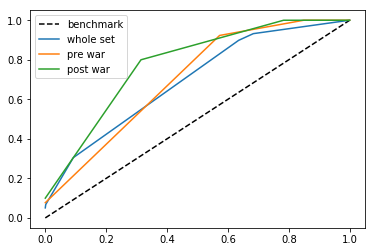

In [12]:
from sklearn import tree
import graphviz 
#criterion=”gini”)
#“entropy” for the information gain
#entropy is nuts

def in_sample_tree(training, maxD = 3, credit=False):
    if credit is True:
        X = training[['lag_2', 'credit']]

    else:
         X = training[['lag_2']]
    y = training['crisisST']
    treeClas = tree.DecisionTreeClassifier(criterion='entropy', max_depth=maxD)
    treeClas.fit(X, y)
    pre_pro = treeClas.predict_proba(X)[:, 1]
    fpr, tpr, thr = roc_curve(y, pre_pro, drop_intermediate=False)
    auc = roc_auc_score(y, pre_pro)
    
    print(auc)
    return fpr, tpr, auc

data_fpr, data_tpr, _ = in_sample_tree(data)
in_sample_tree(data, credit=True)

pre_fpr, pre_tpr, _ = in_sample_tree(preW)
in_sample_tree(preW, credit=True)

post_fpr, post_tpr, _ = in_sample_tree(postW)
in_sample_tree(postW, credit=True)
#by changing maxD, all of these have the protetial to get auc to 1.0

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(pre_fpr,pre_tpr)
plt.plot(post_fpr,post_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])
#picture looks like this is because of the number of threshold
#np.unique(pre_pro).shape == thr.shape == fpr.shape == tpr.shape

#This part really cannot do much compare, since tree has the protential to get 1.0 auc. So this is just a demostration

In [13]:
def out_of_sample_tree(whole, test, maxD = 3, credit=False, pri=False, criterion='gini'):
    if credit is True:
        X = whole[['lag_2', 'credit']]
    else:
         X = whole[['lag_2']]
    y = whole['crisisST']
    
    trainSize = int(whole.shape[0]*(1-test))
    X_train = X[:trainSize]
    X_test = X[trainSize:]
    y_train = y[:trainSize]
    y_test = y[trainSize:]
    if criterion=='gini':
        treeClas = tree.DecisionTreeClassifier(criterion='gini', max_depth=maxD)
    elif criterion=='entropy':
        treeClas = tree.DecisionTreeClassifier(criterion='entropy', max_depth=maxD)
    treeClas.fit(X_train, y_train)
    pre_pro = treeClas.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, pre_pro)
    auc = roc_auc_score(y_test, pre_pro)

    if pri:
        print(auc)
    return fpr, tpr, auc

#out of sample can compare gini and entropy

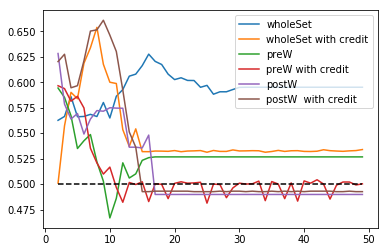

In [14]:
#basically cross validation to get optimal depth
realDeap = 50
testOF = pd.DataFrame(index=range(2, realDeap), columns=['wholeSet', 'wholeSet with credit', 'preW', 'preW with credit', 'postW', 'postW  with credit'])
for maxDeepth in range(2, realDeap):
    totalW = 0.0
    totalWC = 0.0
    totalPre = 0.0
    totalPreC = 0.0
    totalPos = 0.0
    totalPosC = 0.0
    for i in range(2, 6):
        _, _, auc = out_of_sample_tree(data, (1.0/i), maxDeepth)
        totalW += auc
        _, _, auc = out_of_sample_tree(data, (1.0/i), maxDeepth,  True)
        totalWC += auc

        _, _, auc = out_of_sample_tree(preW, (1.0/i), maxDeepth)
        totalPre += auc
        _, _, auc = out_of_sample_tree(preW, (1.0/i), maxDeepth, True)
        totalPreC += auc

        _, _, auc = out_of_sample_tree(postW, (1.0/i), maxDeepth)
        totalPos += auc

        _, _, auc = out_of_sample_tree(postW, (1.0/i), maxDeepth, True)
        totalPosC += auc

    testOF['wholeSet'][maxDeepth] = totalW/4
    testOF['wholeSet with credit'][maxDeepth] = totalWC/4
    testOF['preW'][maxDeepth] = totalPre/4
    testOF['preW with credit'][maxDeepth] = totalPreC/4

    testOF['postW'][maxDeepth] = totalPos/4
    testOF['postW  with credit'][maxDeepth]= totalPosC/4
                
plt.plot(range(2, realDeap), testOF)
plt.plot(range(2, realDeap), np.ones(realDeap - 2)*0.5, 'k--')
plt.legend(['wholeSet', 'wholeSet with credit', 'preW', 'preW with credit', 'postW', 'postW  with credit'])
    


In [15]:
import math
got = {}
for index, row in testOF[testOF==testOF.max(axis=0)].iterrows():
    for key in row.keys():
        if not math.isnan(row[key]):
            got[key] = index
got
    

{'postW': 2,
 'postW  with credit': 9,
 'preW': 2,
 'preW with credit': 2,
 'wholeSet': 16,
 'wholeSet with credit': 8}

0.6734939759036144
0.5804093567251463
0.7161885245901639


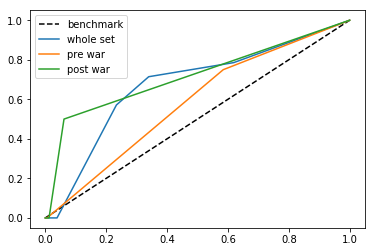

In [16]:
#out of sample test, gini outperform entropy, can quickly run entropy when writing report
data_fpr, data_tpr, _ = out_of_sample_tree(data, 0.3, 8,  True, True)
preW_fpr, preW_tpr, _ = out_of_sample_tree(preW, 0.3, 2, pri=True)
postW_fpr, postW_tpr, _ = out_of_sample_tree(postW, 0.3, 9, True, True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(preW_fpr,preW_tpr)
plt.plot(postW_fpr,postW_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])

In [17]:
print("maxD = 5")
whole_fpr, whole_tpr, _ = out_of_sample_tree(data, 0.3, 5, pri=True)
out_of_sample_tree(data, 0.3, 5,  True, True)
#this data set dont like credit

out_of_sample_tree(preW, 0.3, 5, pri=True)
preW_fpr, preW_tpr, _ = out_of_sample_tree(preW, 0.3, 5, True, True)

out_of_sample_tree(postW, 0.3, 5, pri=True)
postW_fpr, postW_tpr, _ = out_of_sample_tree(postW, 0.3, 5, True, True)
#seems this one is still not overfitting

print("maxD = 2")
out_of_sample_tree(data, 0.3, 2, pri=True)
out_of_sample_tree(data, 0.3, 2,  True, True)
#credit got selected in this one, but end up with worse out of sample predicting power
out_of_sample_tree(preW, 0.3, 2, pri=True)
out_of_sample_tree(preW, 0.3, 2, True, True)
#the output are the same which means within first 2 split, credit didn't get selected

out_of_sample_tree(postW, 0.3, 2, pri=True)
out_of_sample_tree(postW, 0.3, 2, True, True)
#post war always goes well with credit

maxD = 5
0.5981067125645438
0.5781411359724612
0.5190058479532164
0.6008771929824561
0.6075819672131146
0.6844262295081966
maxD = 2
0.5810671256454389
0.5012048192771084
0.5804093567251463
0.5804093567251463
0.6178278688524591
0.625


(array([0.  , 0.25, 1.  ]), array([0. , 0.5, 1. ]), 0.625)

0.9096485819975338


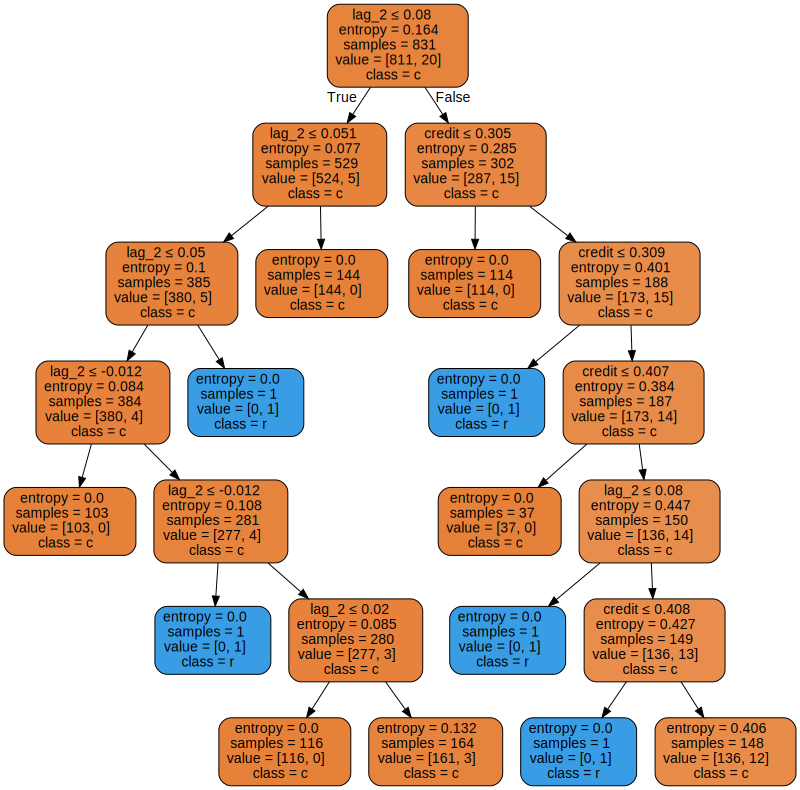

In [18]:

def in_sample_treePlot(training, maxD = 6, credit=False):
    if credit is True:
        X = training[['lag_2', 'credit']]

    else:
         X = training[['lag_2']]
    y = training['crisisST']
    treeClas = tree.DecisionTreeClassifier(criterion='entropy', max_depth=maxD)
    treeClas.fit(X, y)
    pre_pro = treeClas.predict_proba(X)[:, 1]
    fpr, tpr, thr = roc_curve(y, pre_pro, drop_intermediate=False)
    auc = roc_auc_score(y, pre_pro)
    dot_data = tree.export_graphviz(treeClas, out_file=None, 
                         feature_names=['lag_2', 'credit'],  
                         class_names='crisis',  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)
    print(auc)
    return graph

in_sample_treePlot(postW, credit=True)


#in_sample_treePlot(postW, True).render(filename='/home/lin/test')


0.7292162255922292
0.7683182178610367
0.8037333701606592
0.8675597293191547
0.9135018495684339
0.8983662145499384


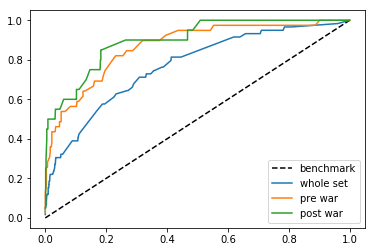

In [19]:
from sklearn.ensemble import RandomForestClassifier
def in_sample_forest(training, maxD = 3, credit=False):
    if credit is True:
        X = training[['lag_2', 'credit']]

    else:
         X = training[['lag_2']]
    y = training['crisisST']
    foreClas = RandomForestClassifier(criterion='gini', max_depth=maxD)
    foreClas.fit(X, y)
    pre_pro = foreClas.predict_proba(X)[:, 1]
    fpr, tpr, thr = roc_curve(y, pre_pro, drop_intermediate=False)
    auc = roc_auc_score(y, pre_pro)
    
    print(auc)
    return fpr, tpr, auc

in_sample_forest(data)
data_fpr, data_tpr, _ = in_sample_forest(data, credit=True)

in_sample_forest(preW)
pre_fpr, pre_tpr, _ = in_sample_forest(preW, credit=True)

in_sample_forest(postW)
post_fpr, post_tpr, _ = in_sample_forest(postW, credit=True)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(pre_fpr,pre_tpr)
plt.plot(post_fpr,post_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])
#with default depth 3, greatly out perform tree

In [20]:
def out_of_sample_forest(whole, test, maxD = 3, credit=False, pri=False, criterion='gini'):
    if credit is True:
        X = whole[['lag_2', 'credit']]
    else:
         X = whole[['lag_2']]
    y = whole['crisisST']
    
    trainSize = int(whole.shape[0]*(1-test))
    X_train = X[:trainSize]
    X_test = X[trainSize:]
    y_train = y[:trainSize]
    y_test = y[trainSize:]
    if criterion=='gini':
        foreClas = RandomForestClassifier(criterion='gini', max_depth=maxD)
    elif criterion=='entropy':
        foreClas = RandomForestClassifier(criterion='entropy', max_depth=maxD)
    foreClas.fit(X_train, y_train)
    pre_pro = foreClas.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, pre_pro)
    auc = roc_auc_score(y_test, pre_pro)

    if pri:
        print(auc)
    return fpr, tpr, auc

#out of sample can compare gini and entropy

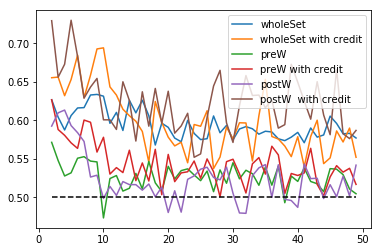

In [29]:
#basically cross validation to get optimal depth
realDeap = 50
testOF = pd.DataFrame(index=range(2, realDeap), columns=['wholeSet', 'wholeSet with credit', 'preW', 'preW with credit', 'postW', 'postW  with credit'])
for maxDeepth in range(2, realDeap):
    totalW = 0.0
    totalWC = 0.0
    totalPre = 0.0
    totalPreC = 0.0
    totalPos = 0.0
    totalPosC = 0.0
    for i in range(2, 6):
        _, _, auc = out_of_sample_forest(data, (1.0/i), maxDeepth)
        totalW += auc
        _, _, auc = out_of_sample_forest(data, (1.0/i), maxDeepth,  True)
        totalWC += auc

        _, _, auc = out_of_sample_forest(preW, (1.0/i), maxDeepth)
        totalPre += auc
        _, _, auc = out_of_sample_forest(preW, (1.0/i), maxDeepth, True)
        totalPreC += auc

        _, _, auc = out_of_sample_forest(postW, (1.0/i), maxDeepth)
        totalPos += auc

        _, _, auc = out_of_sample_forest(postW, (1.0/i), maxDeepth, True)
        totalPosC += auc

    testOF['wholeSet'][maxDeepth] = totalW/4
    testOF['wholeSet with credit'][maxDeepth] = totalWC/4
    testOF['preW'][maxDeepth] = totalPre/4
    testOF['preW with credit'][maxDeepth] = totalPreC/4

    testOF['postW'][maxDeepth] = totalPos/4
    testOF['postW  with credit'][maxDeepth]= totalPosC/4
                
plt.plot(range(2, realDeap), testOF)
plt.plot(range(2, realDeap), np.ones(realDeap - 2)*0.5, 'k--')
plt.legend(['wholeSet', 'wholeSet with credit', 'preW', 'preW with credit', 'postW', 'postW  with credit'])
    
#waht is this pattern? Seems forest already take care of some cross validation

In [30]:
import math
got = {}
for index, row in testOF[testOF==testOF.max(axis=0)].iterrows():
    for key in row.keys():
        if not math.isnan(row[key]):
            got[key] = index
got
    

{'postW': 4,
 'postW  with credit': 5,
 'preW': 2,
 'preW with credit': 2,
 'wholeSet': 9,
 'wholeSet with credit': 10}

0.6639414802065404
0.6195175438596491
0.6915983606557377


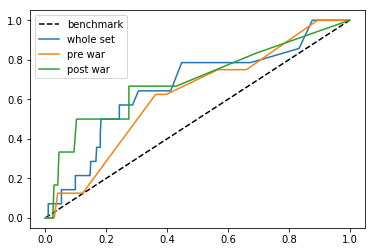

In [31]:
data_fpr, data_tpr, _ = out_of_sample_forest(data, 0.3, 10,  True, True)
preW_fpr, preW_tpr, _ = out_of_sample_forest(preW, 0.3, 2, True, pri=True)#a bit deeper
postW_fpr, postW_tpr, _ = out_of_sample_forest(postW, 0.3, 5, True, True)#max depth lower
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(preW_fpr,preW_tpr)
plt.plot(postW_fpr,postW_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])

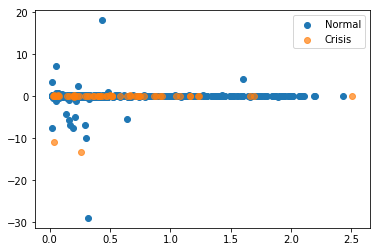

In [32]:
Crisis = data[data['crisisST'] == 1]
Normal = data[data['crisisST'] == 0]
#%matplotlib tk
plt.scatter(Normal['credit'], Normal['lag_2'])
plt.scatter(Crisis['credit'], Crisis['lag_2'], alpha = 0.7)
plt.legend(['Normal', 'Crisis'])
#based on this plot I dont think linear line will do well

0.3312270789969273
0.6492714837942314
0.35303595267688626
0.6519817704736915
0.694327990135635
0.6645499383477188


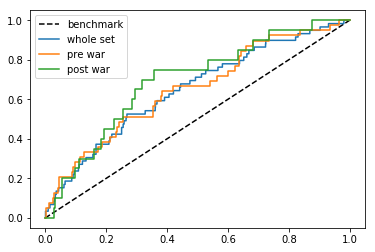

In [55]:
from sklearn.svm import SVC


def in_sample_SVM(training, kernel = 'sigmoid', credit=False):
    if credit is True:
        X = training[['lag_2', 'credit']]

    else:
         X = training[['lag_2']]
    y = training['crisisST']
    svmClas = SVC(kernel=kernel, probability=True)
    svmClas.fit(X, y)
    pre_pro = svmClas.predict_proba(X)[:, 1]
    fpr, tpr, thr = roc_curve(y, pre_pro, drop_intermediate=False)
    auc = roc_auc_score(y, pre_pro)
    
    print(auc)
    return fpr, tpr, auc

in_sample_SVM(data)
data_fpr, data_tpr, _ = in_sample_SVM(data, credit=True)

in_sample_SVM(preW)
pre_fpr, pre_tpr, _ = in_sample_SVM(preW, credit=True)

post_fpr, post_tpr, _ = in_sample_SVM(postW)
in_sample_SVM(postW, credit=True)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(pre_fpr,pre_tpr)
plt.plot(post_fpr,post_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])

In [56]:
#kernel : string, optional (default=’rbf’)
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
#degree : int, optional (default=3)
#study this sigmoid kernel and include in report

In [65]:
def out_of_sample_SVM(whole, test, kernel = 'sigmoid', credit=False):
    if credit is True:
        X = whole[['lag_2', 'credit']]
    else:
         X = whole[['lag_2']]
    y = whole['crisisST']
    
    trainSize = int(whole.shape[0]*(1-test))
    X_train = X[:trainSize]
    X_test = X[trainSize:]
    y_train = y[:trainSize]
    y_test = y[trainSize:]
    
    svmClas = SVC(kernel=kernel, probability=True)
    svmClas.fit(X_train, y_train)
    pre_pro = svmClas.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, pre_pro)
    auc = roc_auc_score(y_test, pre_pro)

    #print(auc)
    return fpr, tpr, auc

In [75]:
totalW = 0.0
totalWC = 0.0
totalPre = 0.0
totalPreC = 0.0
totalPos = 0.0
totalPosC = 0.0
for i in range(2, 6):
    _, _, auc = out_of_sample_SVM(data, (1.0/i))
    totalW += auc
    _, _, auc = out_of_sample_SVM(data, (1.0/i),  credit=True)
    totalWC += auc

    _, _, auc = out_of_sample_SVM(preW, (1.0/i))
    totalPre += auc
    _, _, auc = out_of_sample_SVM(preW, (1.0/i), credit=True)
    totalPreC += auc

    _, _, auc = out_of_sample_SVM(postW, (1.0/i))
    totalPos += auc

    _, _, auc = out_of_sample_SVM(postW, (1.0/i), credit=True)
    totalPosC += auc

print(f'whole set with lag2 loan only: {totalW/4}')
print(f'whole set with lag2 loan and lag1 credit to GDP: {totalWC/4}')
print(f'pre WW2 with lag2 loan only: {totalPre/4}')
print(f'pre WW2 with lag2 loan and lag2 credit to GDP: {totalPreC/4}')
print(f'post WW2 with lag2 loan only: {totalPos/4}')
print(f'post WW2 with lag2 loan and lag2 credit to GDP: {totalPosC/4}')

whole set with lag2 loan only: 0.5783657089018523
whole set with lag2 loan and lag1 credit to GDP: 0.4795640725525544
pre WW2 with lag2 loan only: 0.5618931905043333
pre WW2 with lag2 loan and lag2 credit to GDP: 0.5556235335830428
post WW2 with lag2 loan only: 0.7192570815259356
post WW2 with lag2 loan and lag2 credit to GDP: 0.5326188459503776
